In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [244]:
patient_gene_proj_scores = pd.read_table("../data/processed/allsamples_gene_variability_scores.csv", sep=",")
patient_gene_proj_scores.set_index("patient_id", inplace=True)

In [245]:
patient_gene_proj_scores

,BANK1,BIK,BLK,BTNL2,CDHR5,CEP70,CHD7,CNTNAP2,DAP,DAPK1,...,TNFAIP3,TNFRSF13B,TNFSF4,TNIP1,TNPO3,TSPO,TTLL12,TYK2,UBE2L3,XKR6
patient_id,,,,,,,,,,,,,,,,,,,,,
Betty_Ill_4901_2,4.543426,4.315397,7.554308,14.787151,0.379215,0.529127,7.058008,4.508480,5.303511,5.596666,...,1.615045,1.854821,6.147854,2.531327,3.252360,4.626058,14.677509,2.322530,2.201652,8.243707
ucl223ILL1,7.812316,0.808034,9.546865,23.009482,0.757008,3.288532,35.710019,2.469507,14.007009,14.555934,...,4.886105,1.607361,4.161990,5.393497,3.200672,0.684763,3.145755,0.902030,2.104258,9.626655
Betty_Ill_3822_2,4.297624,1.464830,8.872854,4.373193,0.283669,3.004645,6.409900,3.154451,5.621608,5.648221,...,1.132558,2.379395,3.996258,5.365349,2.932886,1.761504,12.898639,1.034957,1.875921,16.532480
Betty_Ill_5103_2,7.202429,0.533356,2.108174,7.332118,0.425170,0.929420,6.021099,3.527226,5.311540,5.494219,...,3.486573,2.466090,1.858644,6.440220,2.547993,2.632352,10.143327,1.322129,2.092397,5.919384
Betty_Ill_1045_2,6.375874,1.242393,8.167650,10.045328,0.552108,0.814061,5.921651,2.859795,6.322176,6.317476,...,5.887496,2.944000,5.229558,4.928418,2.846442,2.566127,10.808771,1.495729,2.562685,8.475116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40007,8.606496,1.430887,11.575283,19.420497,0.805513,2.762047,6.201703,4.821159,7.562093,7.906954,...,1.623404,2.005835,3.354235,6.928378,4.761586,2.524838,12.280913,3.731808,4.763872,13.320230
32588,6.273376,2.191041,4.316907,5.844346,0.305117,4.535560,12.518715,4.601024,12.419237,14.012239,...,14.463460,3.640093,3.100795,4.288370,3.462439,1.146261,5.525801,3.111818,2.507143,4.109003
55062,6.720956,1.971363,5.667004,12.974628,0.425170,0.657565,10.349475,9.917201,7.112833,7.098817,...,1.904191,1.917151,3.045395,4.130019,2.888869,6.708351,10.688296,1.429172,2.042935,7.851651


In [7]:
pca_projs_concat_df = pd.read_table("../data/interim/PCA_projections_80_variance_SLE_samples.csv", sep=",", 
                                    index_col="Sample ID")

In [248]:
sample_cluster = np.load("../data/interim/new_kmeans_membership_5clusters.npy")
# sample_cluster.set_index("patient_id", inplace=True)
sample_cluster

(634,)

In [270]:
sample_cluster = pd.Series(sample_cluster, index=pca_projs_concat_df.index, name="cluster")

# Predict Cluster from Gene Scores with Logistic Regression

In [249]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [263]:
lr = LogisticRegressionCV(Cs=5, cv=5, penalty="l1", 
                          l1_ratios=np.arange(0, 1, 0.2),
                        solver="saga",
                        multi_class="ovr", n_jobs=4)
print(lr.fit(patient_gene_proj_scores, sample_cluster))

/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1992: UserWarning: l1_ratios parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  self.penalty))
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means

LogisticRegressionCV(Cs=5, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=array([0. , 0.2, 0.4, 0.6, 0.8]), max_iter=100,
                     multi_class='ovr', n_jobs=4, penalty='l1',
                     random_state=None, refit=True, scoring=None, solver='saga',
                     tol=0.0001, verbose=0)


In [264]:
lr.score(patient_gene_proj_scores, sample_cluster)

0.8186119873817035

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

scores = cross_val_score(lr, patient_gene_proj_scores, sample_cluster, cv=5, 
                         scoring="f1_micro")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# gene variability score with Logistic Regression

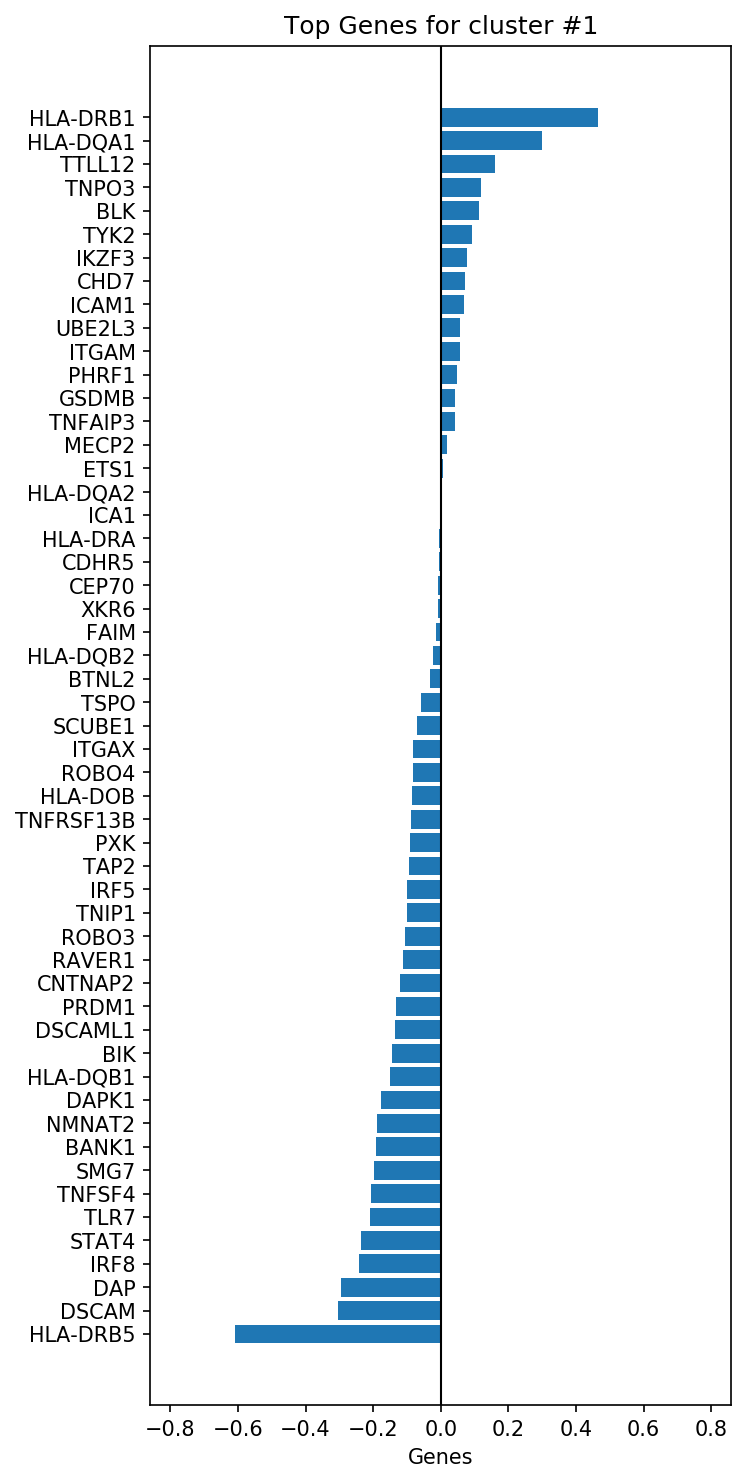

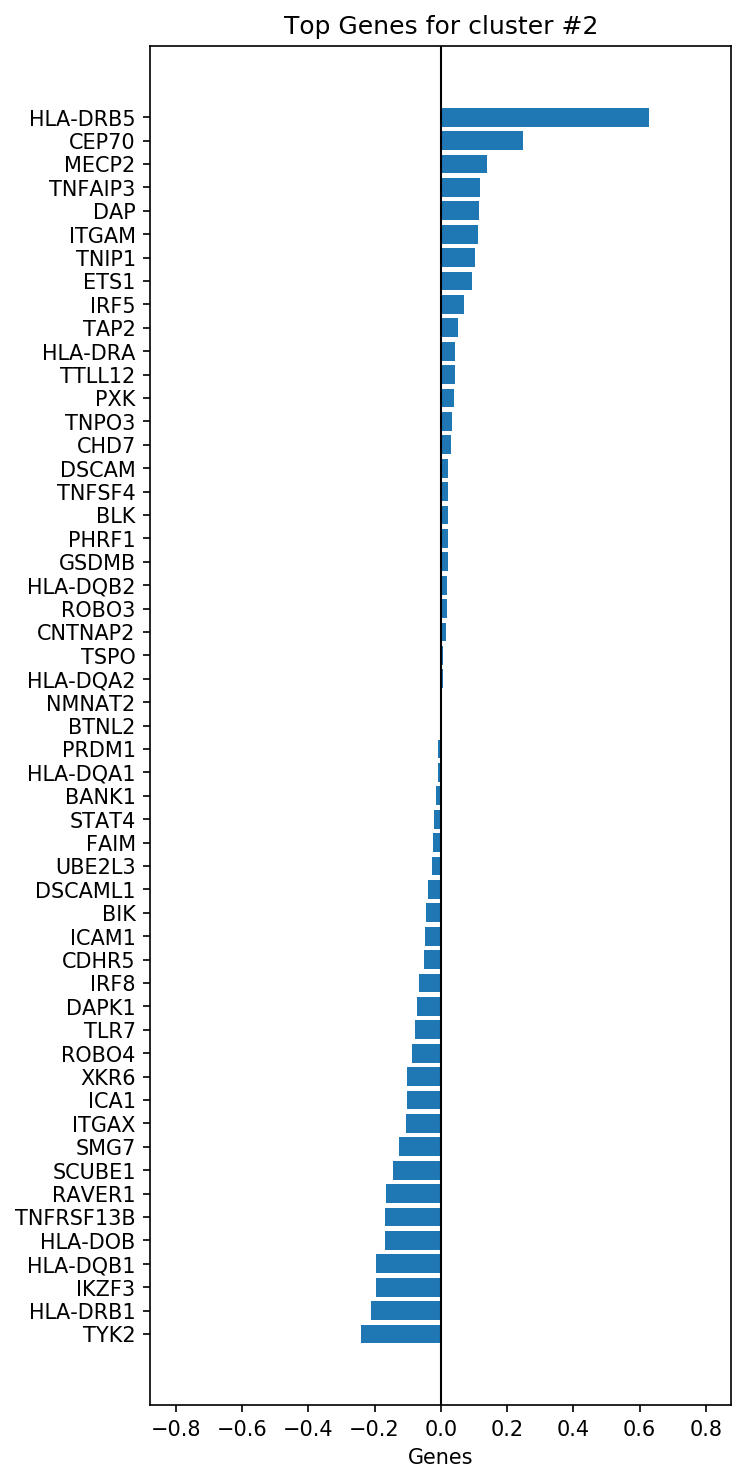

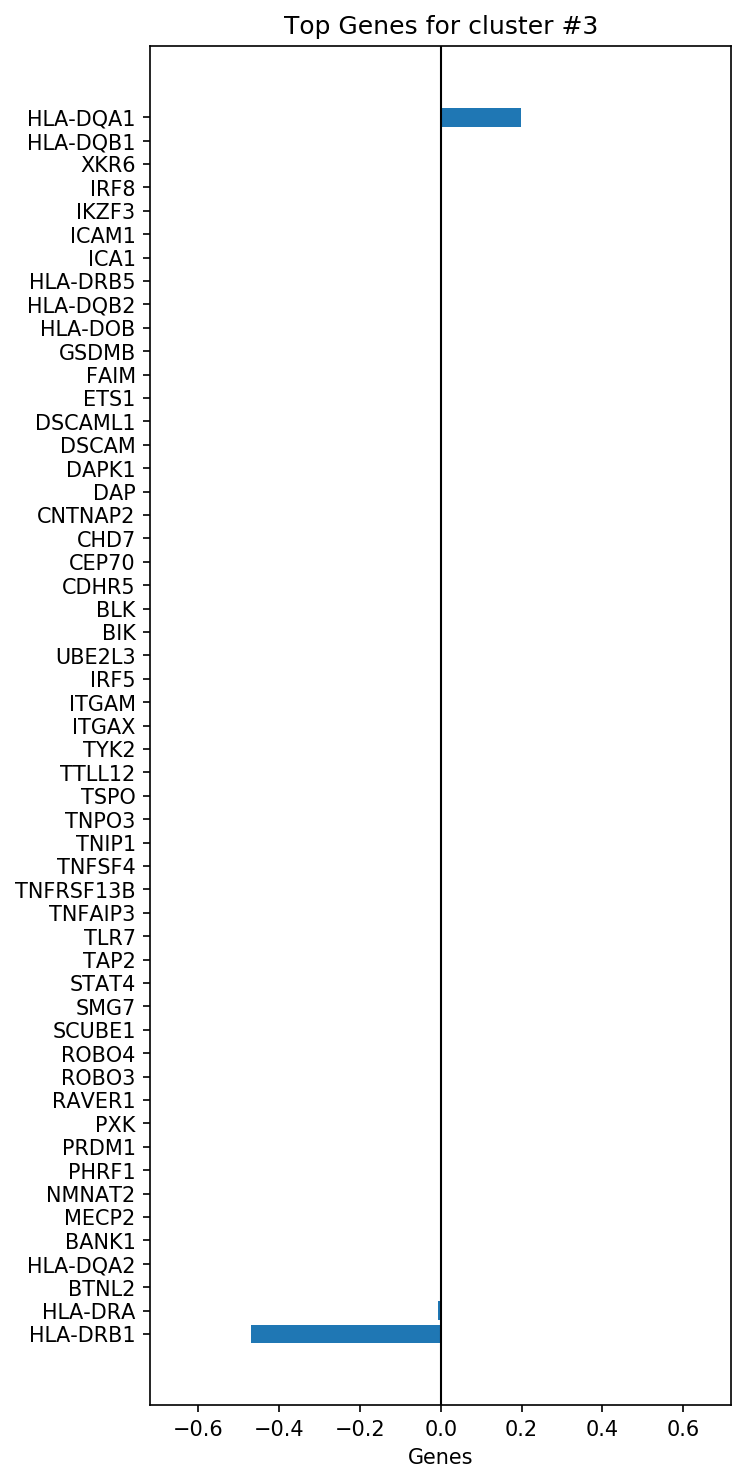

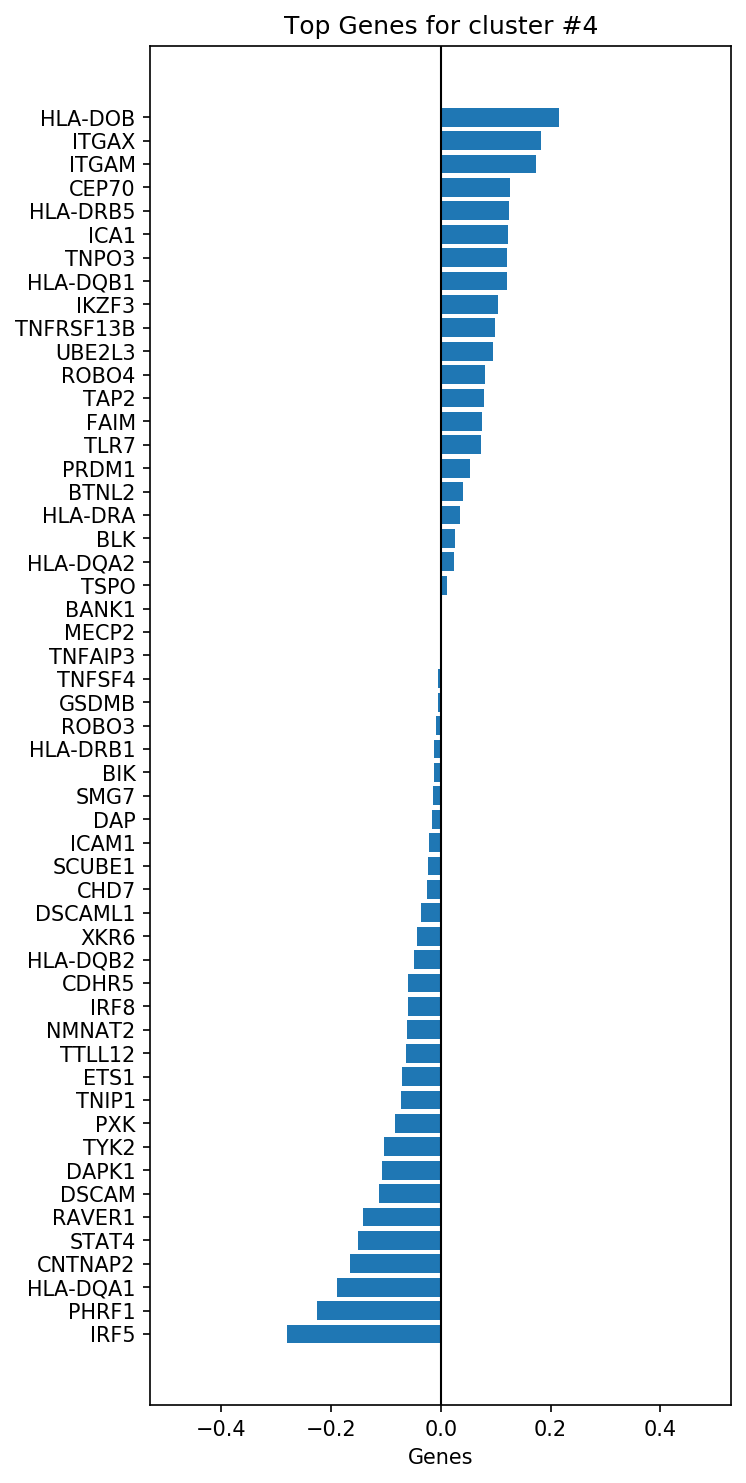

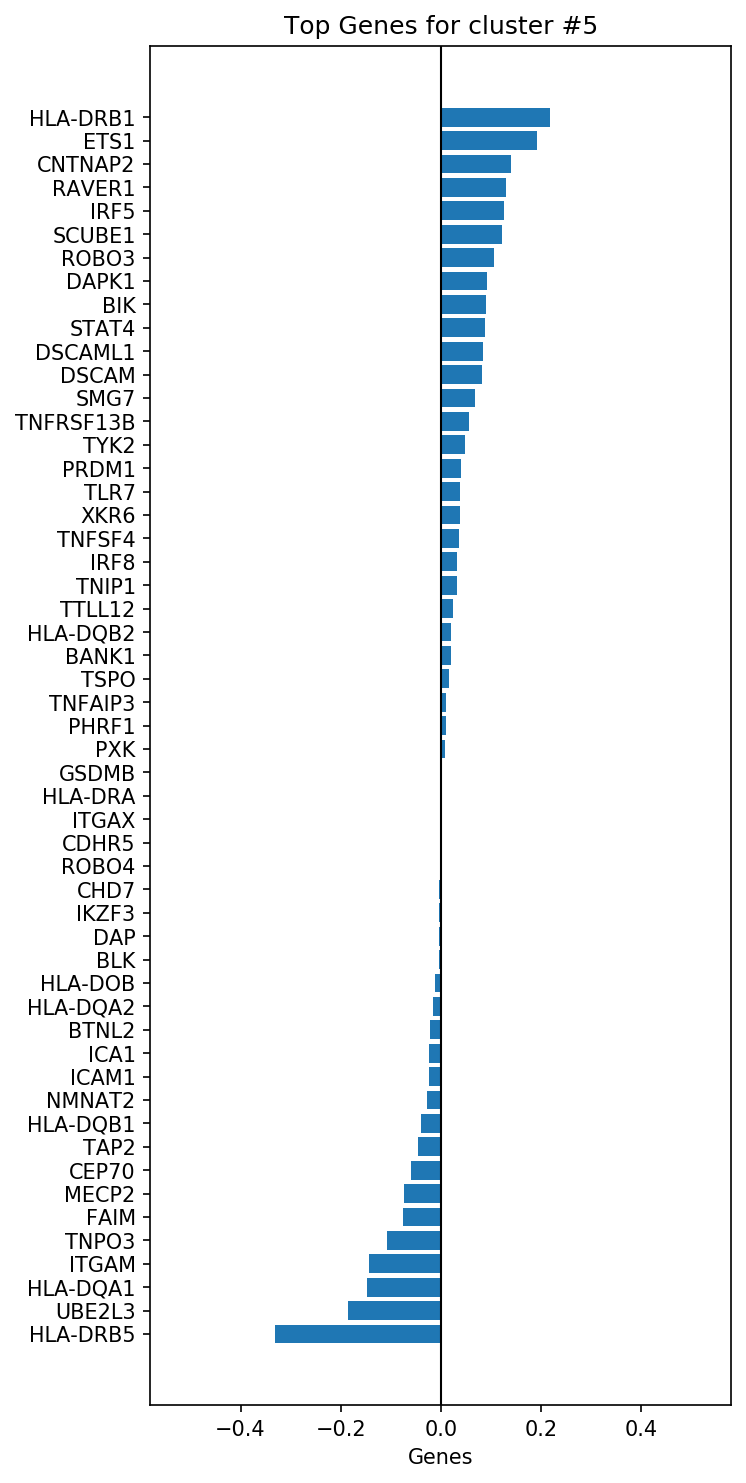

In [265]:
for cluster in range(lr.coef_.shape[0]):
    fig = plt.figure(figsize=(5, 12), dpi=150)
    genes_ordered = np.argsort(lr.coef_[cluster])
    ax = fig.add_subplot(111)
    ax.set_title("Top Genes for cluster #{}".format(cluster+1))
    ax.set_xlabel("Genes")
    ax.axvline(0, color='k',lw=1)   # poor man's zero level
#     ax.spines['bottom'].set_position('center')
#     plt.xticks(rotation=90)
    abs_max = max(np.abs(lr.coef_[cluster]))+0.25
    ax.set_xlim((-abs_max, abs_max))
    ax.barh(y=patient_gene_proj_scores.columns[genes_ordered], 
            width=lr.coef_[cluster][genes_ordered],
           align='center')
    

# Clustering centroids

In [271]:
gene_proj_scores_by_cluster = patient_gene_proj_scores.join(sample_cluster)
gene_proj_scores_cluster_means = gene_proj_scores_by_cluster.groupby("cluster").agg("mean")
gene_center_mean = patient_gene_proj_scores.mean(axis=0)

In [285]:
gene_cluster_sorted

array([22,  0, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 28, 27, 26, 25,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24,
       51, 52])

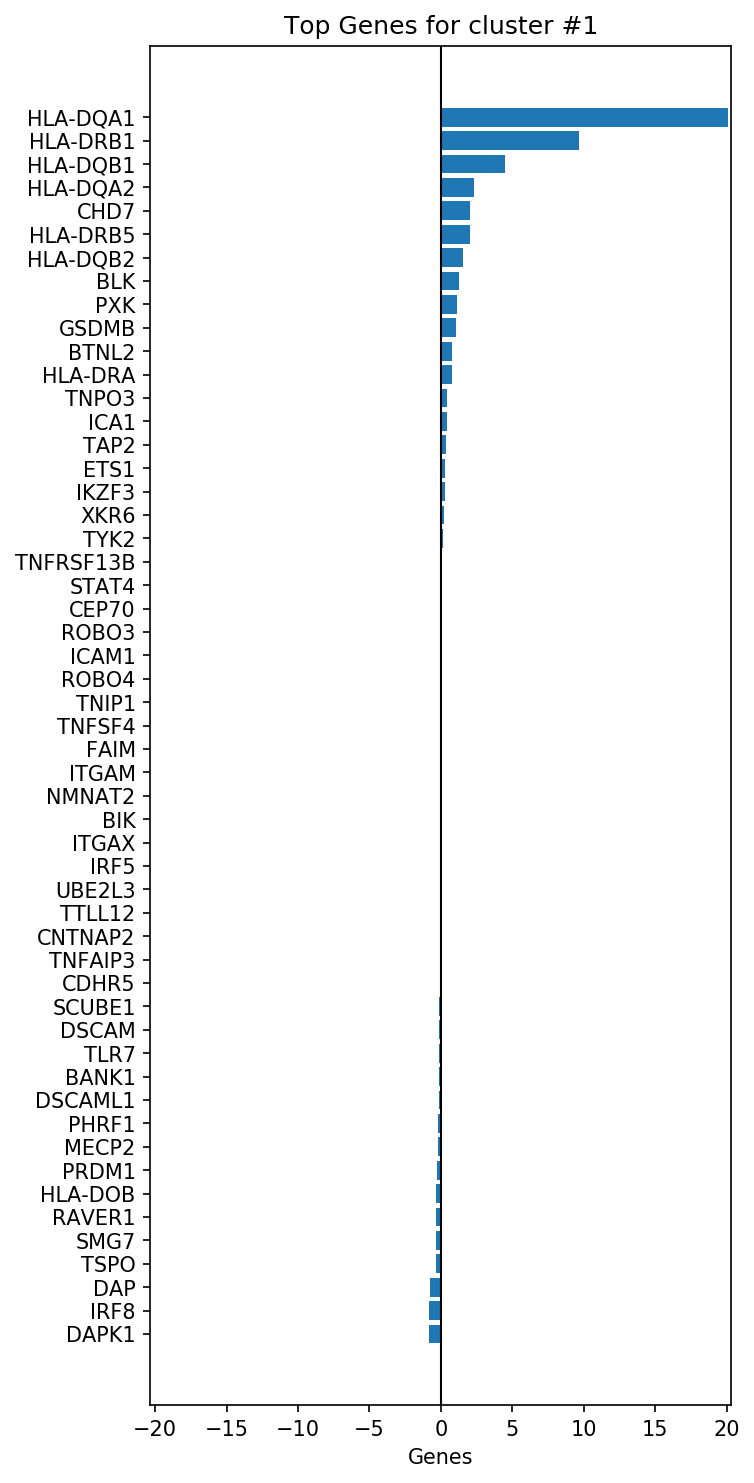

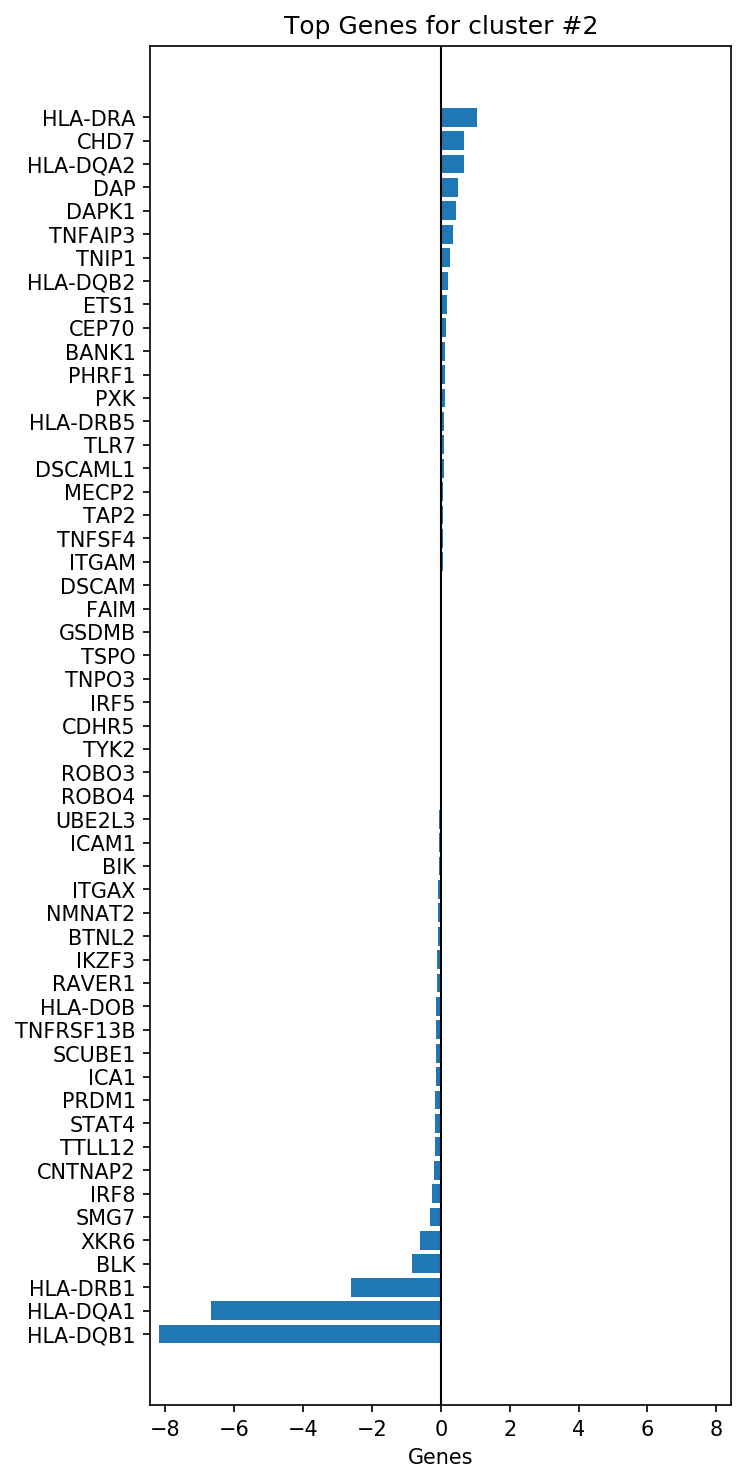

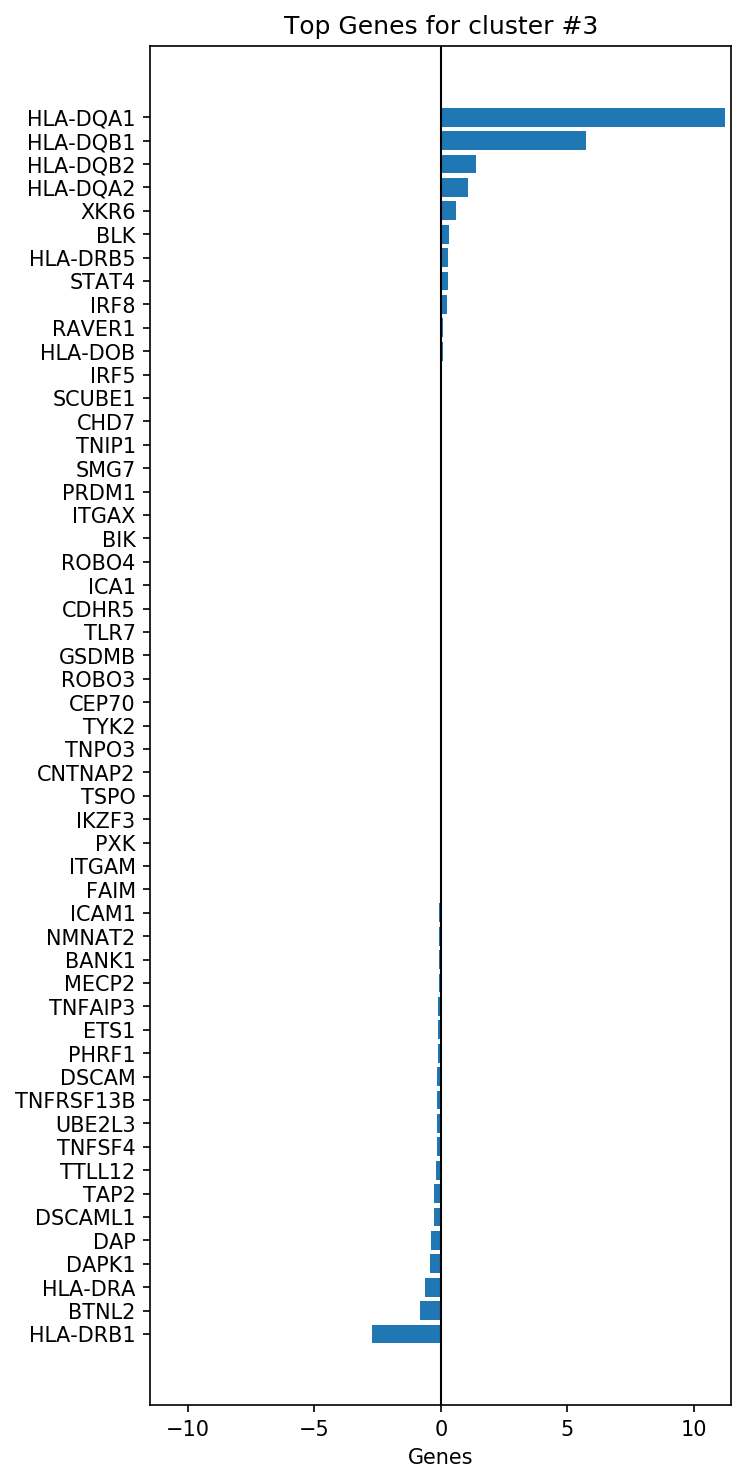

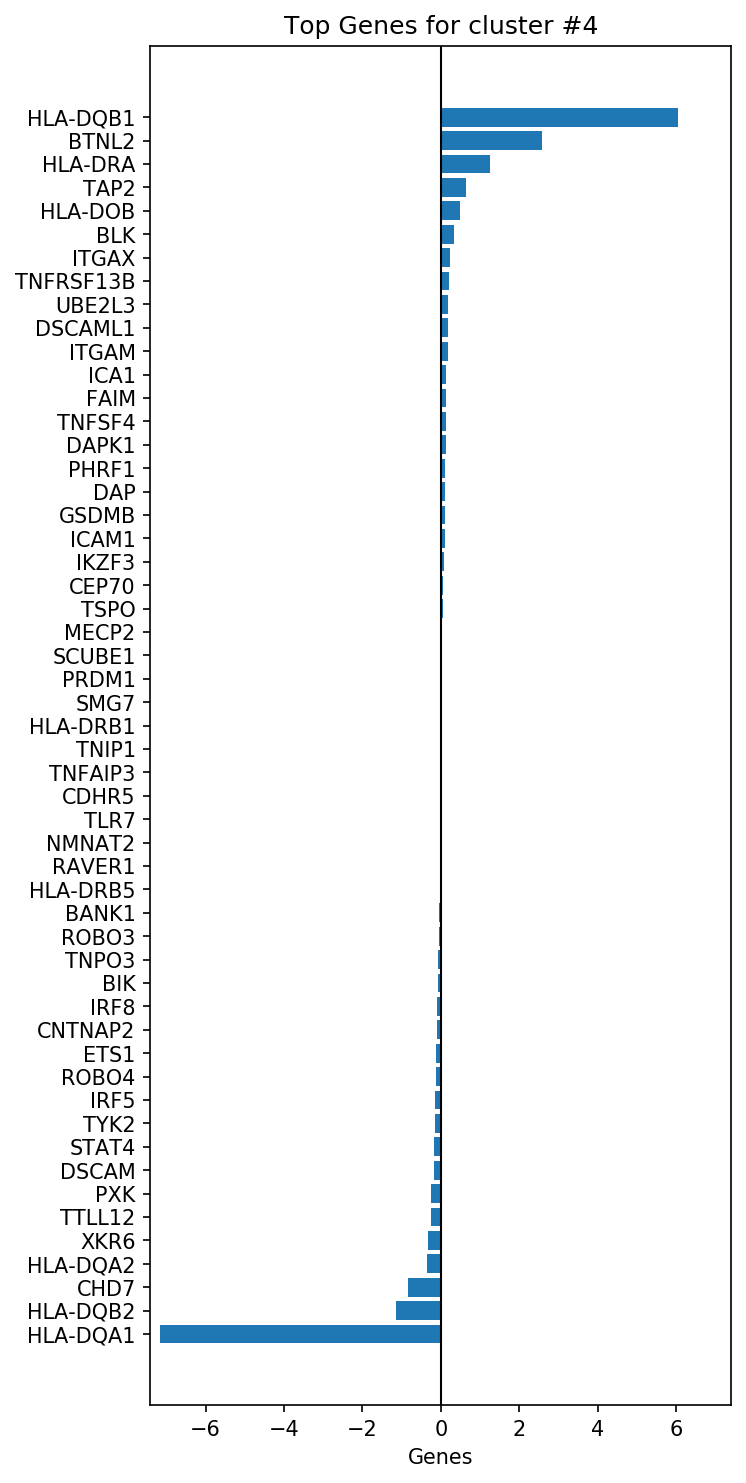

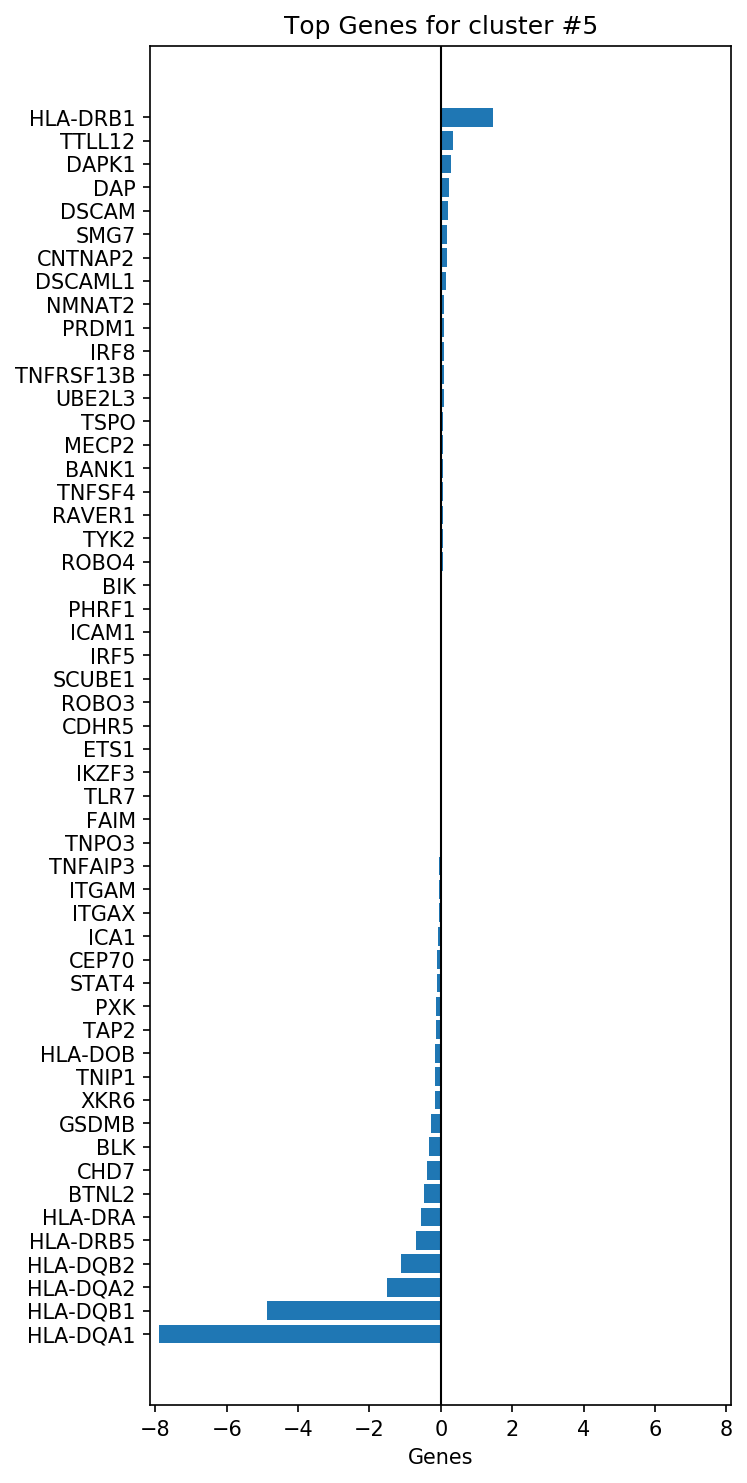

In [287]:
for cluster in range(gene_proj_scores_cluster_means.shape[0]):
    gene_score_diff = gene_proj_scores_cluster_means.iloc[cluster] - gene_center_mean
    fig = plt.figure(figsize=(5, 12), dpi=150)
    genes_ordered = np.argsort(gene_score_diff)
    ax = fig.add_subplot(111)
    ax.set_title("Top Genes for cluster #{}".format(cluster+1))
    ax.set_xlabel("Genes")
    ax.axvline(0, color='k',lw=1)   # poor man's zero level
    abs_max = max(np.abs(gene_score_diff))+0.25
    ax.set_xlim((-abs_max, abs_max))
    ax.barh(y=gene_score_diff.index[genes_ordered], 
            width=gene_score_diff[genes_ordered],
           align='center')

# Cosine similarity between genes by variability

In [273]:
gene_cov = patient_gene_proj_scores.cov()

In [280]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=6)
gene_cluster = sc.fit_predict(gene_cov)
gene_cluster_sorted = np.argsort(gene_cluster)

/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:462: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/Users/jonny/anaconda3/lib/python3.6/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  n_init=n_init)


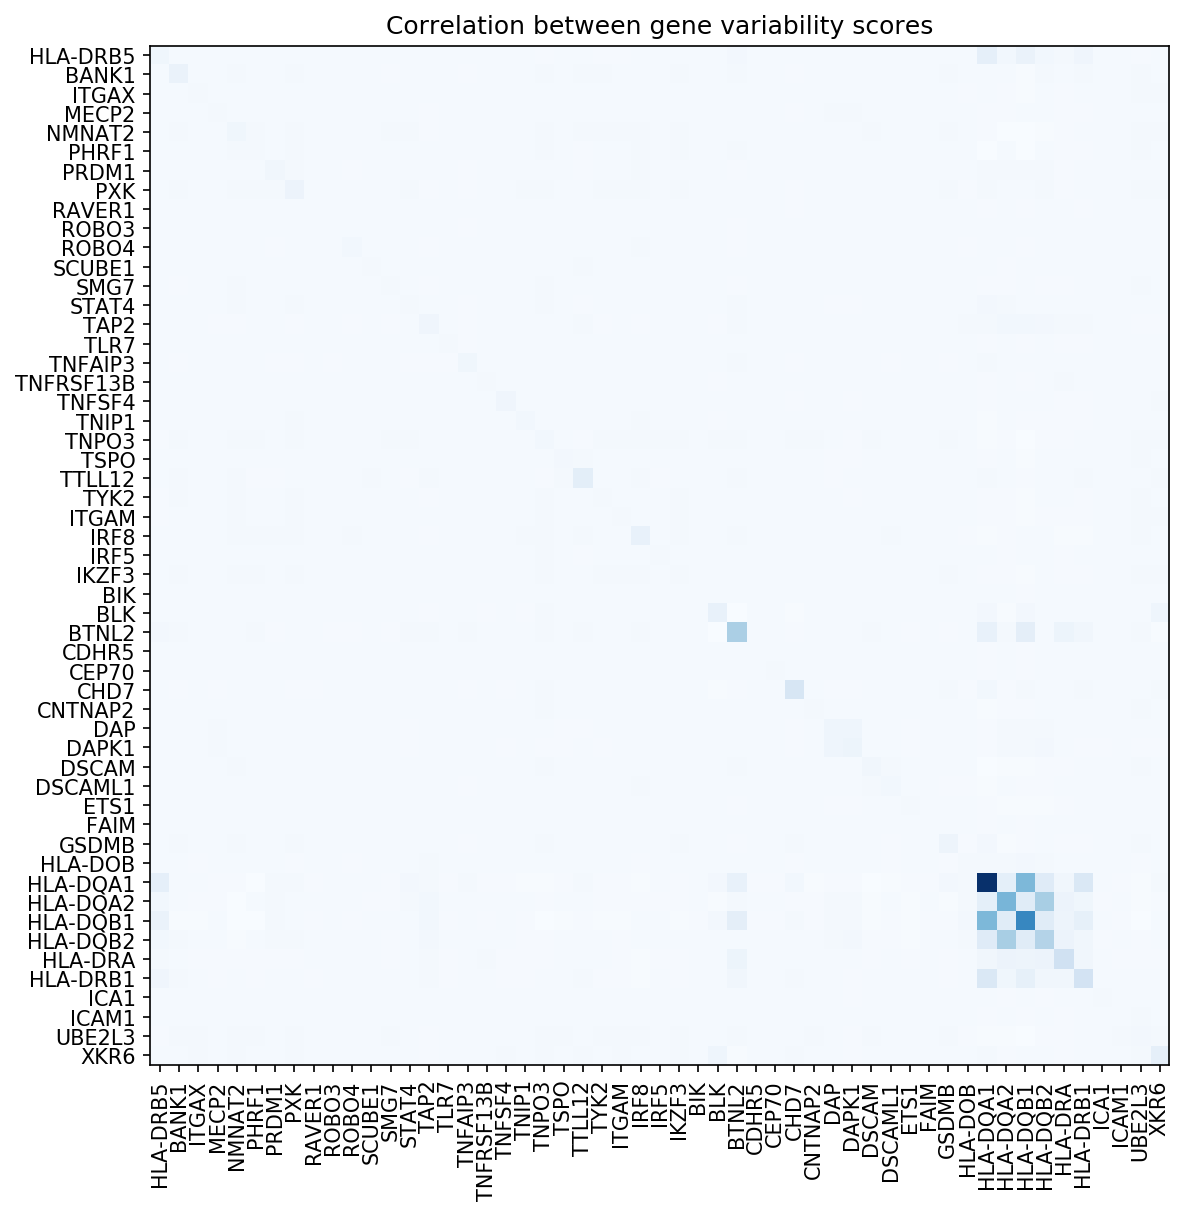

In [281]:
fig, ax = plt.subplots(figsize=(9,9), dpi=150)
genes_list = gene_cov.index[gene_cluster_sorted]
ax.set_title("Correlation between gene variability scores")
ax.set_xticks(np.arange(len(genes_list)))
ax.set_yticks(np.arange(len(genes_list)))
ax.set_xticklabels(genes_list, rotation=90)
ax.set_yticklabels(genes_list)
im = ax.imshow((gene_cov+0.6).iloc[gene_cluster_sorted.tolist(), gene_cluster_sorted.tolist()], cmap="Blues")